In this assignment, we will develop a ML model for cybersecurity intrusion detection. Please
visit the website: https://www.unb.ca/cic/datasets/ids-2017.html and look around to see the problem
space and the evaluation datasets to be used for ML model development.
This dataset was collected by cyber experts during experimentation that was carried out over
the course of 5 days. The description of the experiments also informs the experimental ground
truth.
(Suggested: GeneratedLabelledFlows.zip; note that it is already pre-processed by someone)

1. [10 pts] Download the labeled dataset (if you like, use a dummy email address for
registration). There must be 8 data files, each representing a particular cyber-attack type,
its day, and its collected packet capture (“PCAP”) data.

2. [10 pts] Pick one of the data files, call it Dataset 1, and examine its features. Make sure it
has more than one class value for its label.

In [1]:
!pip install imblearn

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

In [20]:
# Locate and load the data file

df = pd.read_csv('/content/drive/MyDrive/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,...,32,203985.500,5.758373e+05,1629110,379,13800000.0,4.277541e+06,16500000,6737603,BENIGN
1,389,113473706,68,40,11364,12718,403,0,167.117647,171.919413,...,32,178326.875,5.034269e+05,1424245,325,13800000.0,4.229413e+06,16500000,6945512,BENIGN
2,0,119945515,150,0,0,0,0,0,0.000000,0.000000,...,0,6909777.333,1.170000e+07,20400000,6,24400000.0,2.430000e+07,60100000,5702188,BENIGN
3,443,60261928,9,7,2330,4221,1093,0,258.888889,409.702161,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,53,269,2,2,102,322,51,51,51.000000,0.000000,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [21]:
print("Dataset 1 characteristics")
df.info()

Dataset 1 characteristics
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170366 entries, 0 to 170365
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             170366 non-null  int64  
 1    Flow Duration                170366 non-null  int64  
 2    Total Fwd Packets            170366 non-null  int64  
 3    Total Backward Packets       170366 non-null  int64  
 4   Total Length of Fwd Packets   170366 non-null  int64  
 5    Total Length of Bwd Packets  170366 non-null  int64  
 6    Fwd Packet Length Max        170366 non-null  int64  
 7    Fwd Packet Length Min        170366 non-null  int64  
 8    Fwd Packet Length Mean       170366 non-null  float64
 9    Fwd Packet Length Std        170366 non-null  float64
 10  Bwd Packet Length Max         170366 non-null  int64  
 11   Bwd Packet Length Min        170366 non-null  int64  
 12   Bwd Packet Length

In [22]:
df.columns = df.columns.str.strip()

In [23]:
# Checking for duplicates - adapted from Guven, 2024.
df["is_duplicate"]= df.duplicated()
print(f"#duplicated= {len(df[df['is_duplicate']==True])}")

# Drop the duplicate rows using index - best way to drop in pandas
index_to_drop = df[df['is_duplicate']==True].index
df.drop(index_to_drop, inplace=True)

# Remove the duplicate marker column
df.drop(columns='is_duplicate', inplace=True)
print(f'#total= {len(df)}')

#duplicated= 6066
#total= 164300


In [24]:
# Check unique levels and see any marker is used for a missing level
for col in df.columns:
    if df[col].dtype == object:
        print(col, df[col].unique())

Label ['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']


In [25]:
print(f'label distribution: {df.iloc[:, -1].value_counts()}')

label distribution: Label
BENIGN                        162157
Web Attack � Brute Force        1470
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name: count, dtype: int64


In [26]:
print(f"Number of missing values in columns:")
p0 = df.isnull().sum()
print(p0)

Number of missing values in columns:
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64


In [27]:
# Check for any columns that have a high percentage of missing values
high_missing_percentage_cols = p0[p0 > (0.1 * len(df))]
high_missing_percentage_cols

Series([], dtype: int64)

3. [10 pts] For your Dataset 1, pick a machine learning methodology and justify your choice.

#### Ans.
In cybersecurity, especially for intrusion detection, Random Forest is an ideal choice due to its high accuracy, ability to handle imbalanced data, and insight into feature importance. This method uses multiple decision trees to improve predictions and prevent overfitting, which is crucial given the high dimensionality (79 features) and the complex, non-linear relationships in cyber attack datasets. Random Forest's versatility in dealing with both numerical and categorical data further is suitable for cybersecurity tasks.

4. [10 pts] Process the class feature/category as binary classes for supervised learning,
assign BENIGN to value 0 and the rest to value 1. Check its balance for the Dataset 1.

#### Ans.

In [28]:
df['Binary_Label'] = df.iloc[:, -1].apply(lambda x: 0 if x == 'BENIGN' else 1)

binary_label_distribution = df['Binary_Label'].value_counts(normalize=True)
binary_label_distribution

Binary_Label
0    0.986957
1    0.013043
Name: proportion, dtype: float64

The data shows a major imbalance between benign and attack instances, risking bias in machine learning models towards benign cases. To counter this, strategies like oversampling attacks, undersampling benign instances, or using anomaly detection can help. Evaluating models should focus on precision, recall, and F1-scores rather than just accuracy, due to this imbalance.

5. . [10 pts] Explore Dataset 1 features with respect to the class. (Hint: features Source Port and Destination Port are very useful; research and find out important networking portnumbers and one-hot-encode them. Unimportant port numbers or source port numbers canbe assigned to a feature called 'other ports'.)

#### Ans.

- HTTP (80): Widely used for web services, making it a common target for attacks.
- HTTPS (443): Handles secure web traffic but is also a frequent target for attackers.
- FTP (20/21):
  - 20: Used for data transfer in File Transfer Protocol.
  - 21: Control port for FTP, known for command exchanges.
- SSH (22): Secure Shell protocol for secure access to remote computers, often targeted due to its critical role in secure communications.
- Telnet (23): Handles unsecured text communications and is known for its vulnerabilities.
- SMTP (25): Simple Mail Transfer Protocol, essential for email routing, can be exploited for spamming or phishing attacks.
- DNS (53): Domain Name System, crucial for routing web traffic, vulnerable to DNS spoofing attacks.

- SMB (445): Server Message Block, essential for file sharing and network communication in Windows networks, has a history of vulnerabilities.
- RDP (3389): Remote Desktop Protocol, used for remote access to systems, frequently targeted for unauthorized access.
- MSSQL (1433): Microsoft SQL Server's port, critical for database server connections, often targeted for data theft or manipulation.


In [29]:
# Define important ports based on common services and vulnerabilities
important_ports = [20, 21, 22, 23, 25, 53, 80, 443, 445, 3389, 1433]

# One-hot-encode important ports in the Destination Port column
for port in important_ports:
    df[f"Port_{port}"] = (df["Destination Port"] == port).astype(int)

# Aggregate other ports into a single feature
df["Other_Ports"] = (~(df["Destination Port"].isin(important_ports))).astype(int)

port_features = [f"Port_{port}" for port in important_ports] + ["Other_Ports"]
port_feature_distribution = df[port_features + ["Binary_Label"]].groupby("Binary_Label").sum()

port_feature_distribution

,Port_20,Port_21,Port_22,Port_23,Port_25,Port_53,Port_80,Port_443,Port_445,Port_3389,Port_1433,Other_Ports
Binary_Label,,,,,,,,,,,,
0,0,338,792,0,0,74370,17603,34124,130,1,1,34798
1,0,0,0,0,0,0,2143,0,0,0,0,0


6. [10 pts] Display some histograms and anything you deem fit to pick independent Dataset 1 features. (Hint: source/destination bytes, packets, ports and the duration features.)

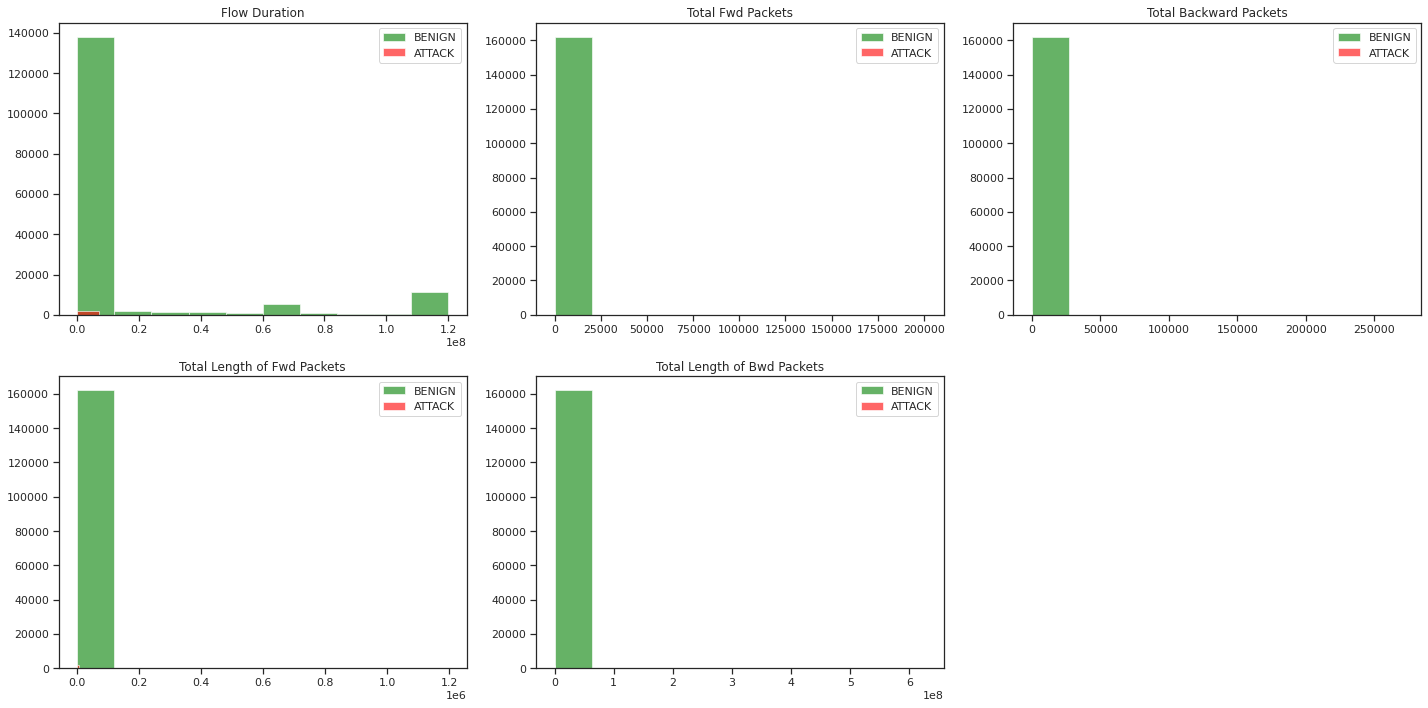

In [30]:

# Function to plot histograms for given features
def plot_histograms(dataframe, features):
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols  # Calculate the required number of rows

    plt.figure(figsize=(20, 5 * n_rows))  # Adjust the figure size as needed
    for i, feature in enumerate(features, 1):
        plt.subplot(n_rows, n_cols, i)
        plt.hist(dataframe[dataframe['Binary_Label'] == 0][feature], color='green', alpha=0.6, label='BENIGN')
        plt.hist(dataframe[dataframe['Binary_Label'] == 1][feature], color='red', alpha=0.6, label='ATTACK')
        plt.title(feature)
        plt.legend()

    plt.tight_layout()
    plt.show()


features_to_plot = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets'] #+ port_features
plot_histograms(df, features_to_plot)

7. [10 pts] Attempt a few classifier models and report their 10-fold CV performances.

In [31]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB  # Importing GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Keeping only the specified features and the target label
features_to_keep = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets'] + port_features + ['Binary_Label']
df_filtered = df[features_to_keep]

X = df_filtered.drop(columns=['Binary_Label'])
y = df_filtered['Binary_Label']

classifiers = {
    "Random Forest": make_pipeline_imb(SMOTE(), RandomForestClassifier(n_estimators=100)),
    "Gradient Boosting": make_pipeline_imb(SMOTE(), GradientBoostingClassifier(n_estimators=100)),
    "Logistic Regression": make_pipeline_imb(SMOTE(), StandardScaler(), LogisticRegression(max_iter=1000)),
    "Naive Bayes": make_pipeline_imb(SMOTE(), GaussianNB()),
    # "SVM": make_pipeline_imb(SMOTE(), StandardScaler(), SVC())  # SVM is taking too much time to run
}

cv_results_f1 = {}

# Perform 10-fold cross-validation for each classifier using F1-score as the scoring metric
for classifier_name, classifier in tqdm(classifiers.items(), desc="Evaluating Classifiers"):
    scores = cross_val_score(classifier, X, y, cv=10, scoring=make_scorer(f1_score))
    cv_results_f1[classifier_name] = {
        'Mean F1 Score': np.mean(scores),
        'Standard Deviation': np.std(scores)
    }

cv_results_f1


Evaluating Classifiers: 100%|██████████| 4/4 [16:23<00:00, 245.87s/it]


{'Random Forest': {'Mean F1 Score': 0.8212847111764805,
  'Standard Deviation': 0.03795189164067799},
 'Gradient Boosting': {'Mean F1 Score': 0.7615732847783708,
  'Standard Deviation': 0.04600111294287918},
 'Logistic Regression': {'Mean F1 Score': 0.2699306300416912,
  'Standard Deviation': 0.024535720270098087},
 'Naive Bayes': {'Mean F1 Score': 0.028556644575063718,
  'Standard Deviation': 0.0007628105625244412}}

8. [10 pts] Convert your code to be used for the remaining 7 datasets, i.e., Datasets 2-8

In [32]:
# Function for preprocessing a single dataset
def preprocess_dataset(file_path):

    df = pd.read_csv(file_path)

    df.columns = df.columns.str.strip()


    df["is_duplicate"] = df.duplicated()
    df.drop(df[df["is_duplicate"]].index, inplace=True)
    df.drop(columns="is_duplicate", inplace=True)

    df['Binary_Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

    important_ports = [20, 21, 22, 23, 25, 53, 80, 443, 445, 3389, 1433]

    # One-hot-encode important ports and aggregate others
    for port in important_ports:
        df[f"Port_{port}"] = (df["Destination Port"] == port).astype(int)
    df["Other_Ports"] = (~(df["Destination Port"].isin(important_ports))).astype(int)

    # Select features to keep
    features_to_keep = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
                        'Total Length of Fwd Packets', 'Total Length of Bwd Packets'] + \
                       [f"Port_{port}" for port in important_ports] + ["Other_Ports", 'Binary_Label']
    df_filtered = df[features_to_keep]

    X = df_filtered.drop(columns=['Binary_Label'])
    y = df_filtered['Binary_Label']

    return X, y

# List of file paths for Datasets 2-8
file_paths = [
    '/content/drive/MyDrive/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    '/content/drive/MyDrive/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    '/content/drive/MyDrive/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    '/content/drive/MyDrive/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv',
    '/content/drive/MyDrive/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    '/content/drive/MyDrive/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv',
    '/content/drive/MyDrive/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv',
]

9. [10 pts] Pick a classifier algorithm and report its evaluation for the remaining 7 datasets. Note that one dataset has a single class, which might need an unsupervised learning.

In [33]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Function to evaluate Random Forest on a given dataset
def evaluate_random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Traindd the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Generate and print the classification report
    report = classification_report(y_test, y_pred)
    print(report)

# Loop over each dataset and evaluate the classifier
for file_path in file_paths:
    X, y = preprocess_dataset(file_path)

    # Check if the dataset has more than one class
    if len(y.unique()) > 1:
        print(f"Evaluating Random Forest on {file_path}")
        evaluate_random_forest(X, y)
    else:
        print(f"Skipping {file_path} as it contains only one class. Consider unsupervised learning.")

Evaluating Random Forest on /content/drive/MyDrive/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28455
           1       1.00      1.00      1.00     38479

    accuracy                           1.00     66934
   macro avg       1.00      1.00      1.00     66934
weighted avg       1.00      1.00      1.00     66934

Evaluating Random Forest on /content/drive/MyDrive/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36811
           1       1.00      1.00      1.00     27424

    accuracy                           1.00     64235
   macro avg       1.00      1.00      1.00     64235
weighted avg       1.00      1.00      1.00     64235

Evaluating Random Forest on /content/drive/MyDrive/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_I

10. [10 pts] Briefly write up your thoughts about developing a machine learning model where you are not a subject matter expert, such as, developing a cybersecurity intrusion detection pipeline as in this assignment.

#### Ans.

Developing a machine learning model in a domain like cybersecurity intrusion detection without prior expertise brings challenges especially navigating through domain-specific data, understanding the nuances of feature selection, and accurately evaluating model performance can be daunting. The complexity of cybersecurity data, including distinguishing between benign and malicious activities, requires a nuanced approach to model building and validation. That said, leveraging methodologies from other domains can compensate for the lack of specific domain knowledge, potentially uncovering hidden patterns and insights within the data that could be crucial for detecting cyber threats.